In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("laptop_data.csv")

In [3]:
df.head()

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080


In [4]:
df.shape

(1303, 12)

In [5]:
df.size

15636

In [6]:
df.describe()

,Unnamed: 0,Inches,Price
count,1303.00000,1303.000000,1303.000000
mean,651.00000,15.017191,59870.042910
std,376.28801,1.426304,37243.201786
min,0.00000,10.100000,9270.720000
25%,325.50000,14.000000,31914.720000
50%,651.00000,15.600000,52054.560000
75%,976.50000,15.600000,79274.246400
max,1302.00000,18.400000,324954.720000


In [7]:
df.isnull().sum()

Unnamed: 0          0
Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
dtype: int64

In [8]:
df.columns

Index(['Unnamed: 0', 'Company', 'TypeName', 'Inches', 'ScreenResolution',
       'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Price'],
      dtype='object')

In [9]:
# basic cleaning
df['Ram'] = df['Ram'].str.replace('GB', '').astype(int)

In [10]:
df['Weight'] = df['Weight'].str.replace('kg', '').astype(float)

In [11]:
# Creating Touchscreen column
df['Touchscreen'] = df['ScreenResolution'].apply(lambda x: 1 if 'Touchscreen' in x else 0)

# Creatinng IPS column
df['Ips'] = df['ScreenResolution'].apply(lambda x: 1 if 'IPS' in x else 0)

# Extracting resolution (X_res & Y_res)
resolutions = df['ScreenResolution'].str.extract(r'(\d+)x(\d+)')
df['X_res'] = resolutions[0].astype(float)
df['Y_res'] = resolutions[1].astype(float)

# Calculating PPI
df['PPI'] = ((df['X_res']**2 + df['Y_res']**2) ** 0.5) / df['Inches']

# Droping the original column
df.drop(columns=['ScreenResolution'], inplace=True)

In [12]:
def extract_cpu_type(text):
    if "Intel Core i7" in text:
        return "Intel Core i7"
    elif "Intel Core i5" in text:
        return "Intel Core i5"
    elif "Intel Core i3" in text:
        return "Intel Core i3"
    elif "Intel Pentium" in text:
        return "Intel Pentium"
    elif "Intel Celeron" in text:
        return "Intel Celeron"
    elif "AMD Ryzen 7" in text:
        return "AMD Ryzen 7"
    elif "AMD Ryzen 5" in text:
        return "AMD Ryzen 5"
    elif "AMD Ryzen 3" in text:
        return "AMD Ryzen 3"
    elif "Apple M1" in text:
        return "Apple M1"
    else:
        return "Other"

df['Cpu_Brand'] = df['Cpu'].apply(extract_cpu_type)
df.drop(columns=['Cpu'], inplace=True)

In [13]:
df['Gpu_Brand'] = df['Gpu'].apply(lambda x: x.split()[0])
df.drop(columns=['Gpu'], inplace=True)

In [14]:
# Cleaning memory 
'256GB SSD + 1TB HDD'
'1TB HDD'
'512GB SSD'
'128GB SSD + 1TB HDD'

'128GB SSD + 1TB HDD'

In [15]:
# Fixing a 'Memory' Column 
import re

# Functioning to convert memory string to total SSD & HDD
def extract_memory_fixed(mem_string):
    mem_string = mem_string.upper()
    mem_string = mem_string.replace('TB', '000GB')  # 1TB → 1000GB
    mem_string = mem_string.replace('GB', '')
    mem_string = mem_string.replace('FLASH STORAGE', 'SSD')
    mem_string = mem_string.replace('HYBRID', 'HDD')

    # Initializing
    hdd = 0
    ssd = 0

    # Extracting parts
    parts = mem_string.split('+')
    for part in parts:
        part = part.strip()
        if 'HDD' in part:
            try:
                hdd += int(re.findall(r'\d+', part)[0])
            except:
                hdd += 0
        elif 'SSD' in part:
            try:
                ssd += int(re.findall(r'\d+', part)[0])
            except:
                ssd += 0

    return pd.Series([hdd, ssd])

# Applying to dataframe
df[['HDD', 'SSD']] = df['Memory'].apply(extract_memory_fixed)
df.drop(columns=['Memory'], inplace=True)

In [16]:
df[['HDD', 'SSD']].head()

,HDD,SSD
0,0,128
1,0,128
2,0,256
3,0,512
4,0,256


In [17]:
# Droping unnecessary columns
df.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')  # only if it exists

In [18]:
from sklearn.preprocessing import LabelEncoder

# Making a copy to preserve original
df_encoded = df.copy()

# Applying LabelEncoder to all object (categorical) columns
le = LabelEncoder()
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

In [19]:
# Defining X and y
X = df_encoded.drop('Price', axis=1)
y = df_encoded['Price']

In [20]:
from sklearn.model_selection import train_test_split

# Split data to 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error

# Initializing and training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predicting
y_pred = model.predict(X_test)

# Evaluating
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R2 Score: {r2:.2f}")
print(f"Mean Absolute Error: ₹{mae:.0f}")

R2 Score: 0.81
Mean Absolute Error: ₹9734


C:\Users\Admin\AppData\Local\Temp\ipykernel_10444\2522667529.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')


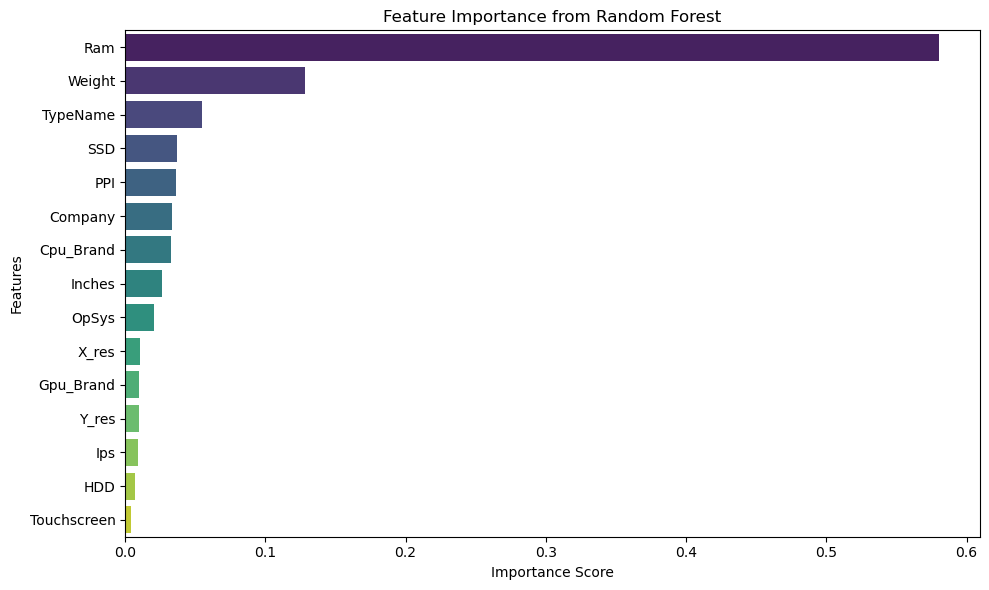

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Geting feature importances from the trained model
importances = model.feature_importances_
feature_names = X.columns

# Creating a DataFrame for plotting
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Ploting
plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

In [23]:
# building a pipeline

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
import pandas as pd

In [25]:
X = df.drop('Price', axis=1)
y = df['Price']

In [26]:
categorical_cols = X.select_dtypes(include='object').columns.tolist()
numerical_cols = X.select_dtypes(exclude='object').columns.tolist()

In [27]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
])

In [28]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],}

In [31]:
grid = GridSearchCV(pipe, param_grid, cv=3, scoring='r2', n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Inches',
                                                                          'Ram',
                                                                          'Weight',
                                                                          'Touchscreen',
                                                                          'Ips',
                                                                          'X_res',
                                                                          'Y_res',
                                                                          'PPI',
                                                                          'HDD',
                                                                          'SSD']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Company',
                                                                          'TypeName',
                                                                          'OpSys',
                                                                          'Cpu_Brand',
                                                                          'Gpu_Brand'])])),
                                       ('model', RandomForestRegressor())]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__min_samples_split': [2, 5],
                         'model__n_estimators': [100, 200]},
             scoring='r2', verbose=2)

In [32]:
print("Best Params:", grid.best_params_)

best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

print(" R2 Score (Tuned):", r2_score(y_test, y_pred))
print(" MAE (Tuned): ₹", int(mean_absolute_error(y_test, y_pred)))

Best Params: {'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 100}
 R2 Score (Tuned): 0.8151089795742861
 MAE (Tuned): ₹ 9742


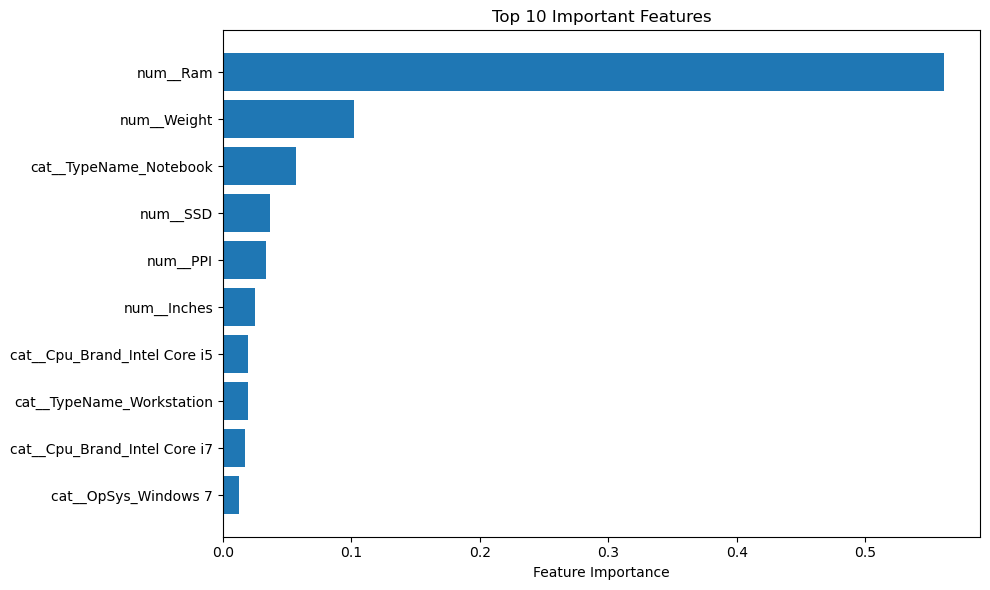

In [33]:
import matplotlib.pyplot as plt
import numpy as np

importances = best_model.named_steps['model'].feature_importances_
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

sorted_idx = np.argsort(importances)[::-1][:10]

plt.figure(figsize=(10, 6))
plt.barh(range(10), importances[sorted_idx][::-1], align='center')
plt.yticks(range(10), feature_names[sorted_idx][::-1])
plt.xlabel("Feature Importance")
plt.title("Top 10 Important Features")
plt.tight_layout()
plt.show()

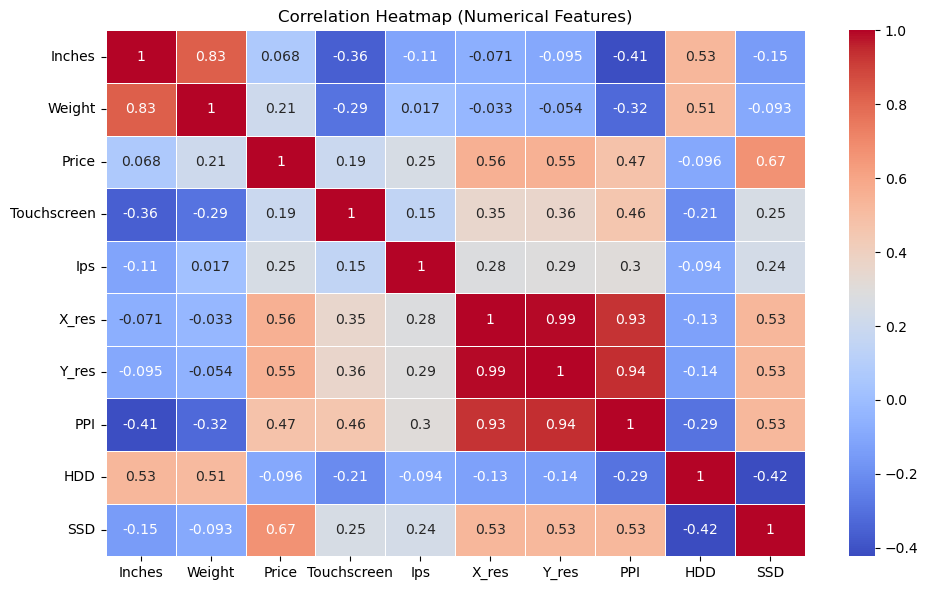

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap (Numerical Features)")
plt.tight_layout()
plt.show()

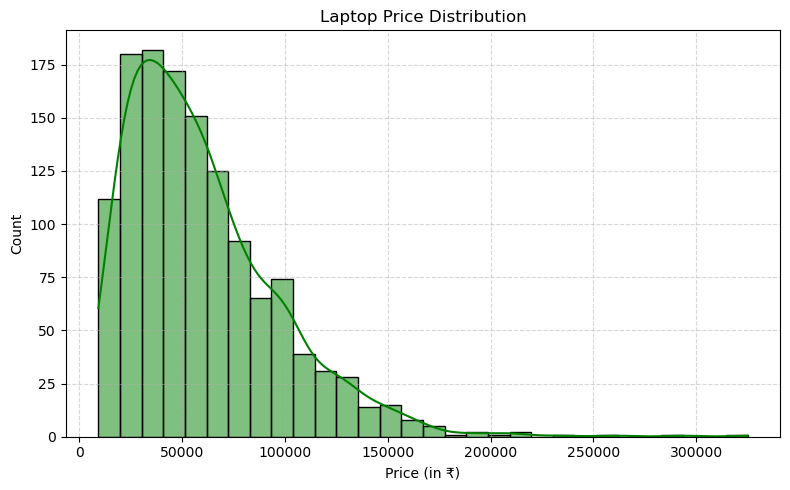

In [35]:
plt.figure(figsize=(8, 5))
sns.histplot(df['Price'], bins=30, kde=True, color='green')
plt.title("Laptop Price Distribution")
plt.xlabel("Price (in ₹)")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

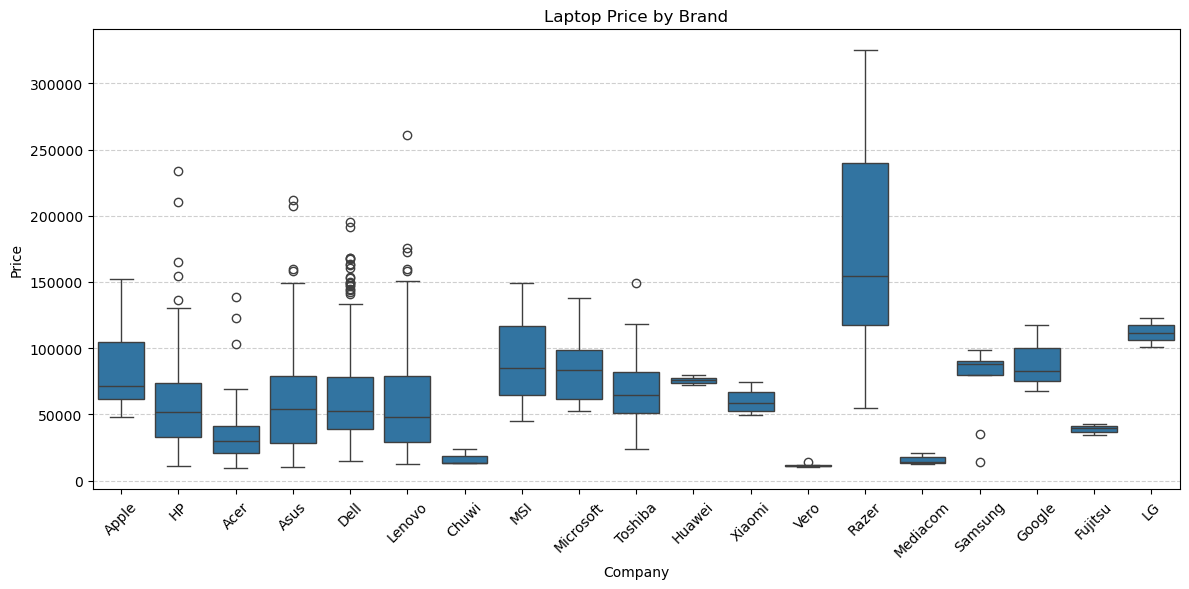

In [36]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Company', y='Price', data=df)
plt.title("Laptop Price by Brand")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

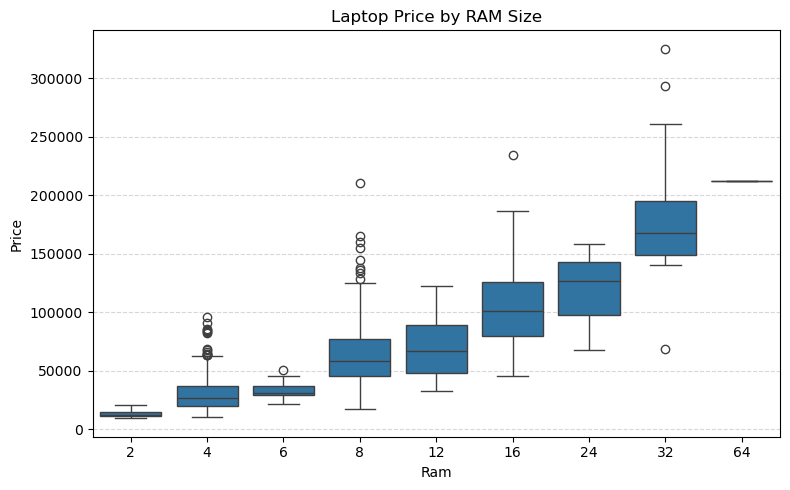

In [37]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='Ram', y='Price', data=df)
plt.title("Laptop Price by RAM Size")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

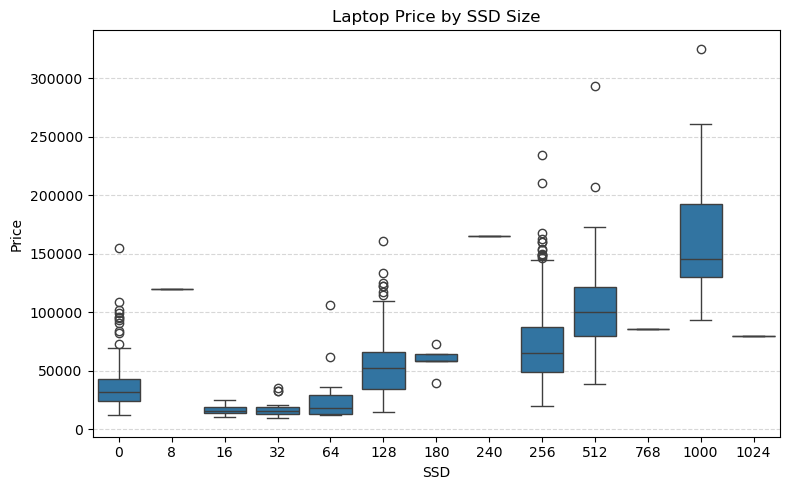

In [38]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='SSD', y='Price', data=df)
plt.title("Laptop Price by SSD Size")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [57]:
import joblib
joblib.dump(best_model,'laptop_price_predictor.pkl') 

['laptop_price_predictor.pkl']

In [ ]:
#!pip install gradio

In [59]:
df.columns

Index(['Company', 'TypeName', 'Inches', 'Ram', 'OpSys', 'Weight', 'Price',
       'Touchscreen', 'Ips', 'X_res', 'Y_res', 'PPI', 'Cpu_Brand', 'Gpu_Brand',
       'HDD', 'SSD'],
      dtype='object')

In [71]:
import gradio as gr
import numpy as np
import pandas as pd

# Loading the trained model
model = joblib.load('laptop_price_predictor.pkl')

In [73]:
def predict_price(Company, TypeName, Inches, Ram, OpSys, Weight,
                  Touchscreen, Ips, X_res, Y_res, Cpu_Brand, Gpu_Brand, HDD, SSD):
    try:
        # Convert binary categorical to numeric
        Touchscreen = 1 if Touchscreen == "Yes" else 0
        Ips = 1 if Ips == "Yes" else 0
        Ram = int(Ram)
        Inches = float(Inches)
        Weight = float(Weight)
        X_res = int(X_res)
        Y_res = int(Y_res)
        HDD = int(HDD)
        SSD = int(SSD)

        # Calculate PPI
        PPI = ((X_res**2 + Y_res**2)**0.5) / Inches

        # Preparing input as DataFrame with column names
        input_dict = {
            'Company': [Company],
            'TypeName': [TypeName],
            'Inches': [Inches],
            'Ram': [Ram],
            'OpSys': [OpSys],
            'Weight': [Weight],
            'Touchscreen': [Touchscreen],
            'Ips': [Ips],
            'X_res': [X_res],
            'Y_res': [Y_res],
            'PPI': [PPI],
            'Cpu_Brand': [Cpu_Brand],
            'Gpu_Brand': [Gpu_Brand],
            'HDD': [HDD],
            'SSD': [SSD]
        }

        input_df = pd.DataFrame(input_dict)

        # Predicting
        prediction = model.predict(input_df)
        return f" Estimated Laptop Price: ₹{int(prediction[0]):,}"

    except Exception as e:
        return f"Prediction failed: {str(e)}"

In [75]:
# Defining input components
inputs = [
    gr.Dropdown(['Dell', 'HP', 'Lenovo', 'Asus', 'Acer', 'Apple', 'MSI', 'Toshiba', 'Samsung', 'Razer', 'Microsoft', 'Chuwi', 'Google', 'Fujitsu', 'LG'], label="Company"),
    gr.Dropdown(['Notebook', 'Ultrabook', 'Gaming', '2 in 1 Convertible', 'Workstation', 'Netbook'], label="TypeName"),
    gr.Slider(10.0, 18.0, step=0.1, label="Screen Size (Inches)"),
    gr.Slider(2, 64, step=2, label="RAM (GB)"),
    gr.Dropdown(['Windows', 'Mac', 'Linux', 'No OS', 'Chrome OS'], label="Operating System"),
    gr.Slider(0.5, 4.0, step=0.1, label="Weight (kg)"),
    gr.Radio(['Yes', 'No'], label="Touchscreen"),
    gr.Radio(['Yes', 'No'], label="IPS Panel"),
    gr.Number(label="Screen Resolution X (e.g. 1920)"),
    gr.Number(label="Screen Resolution Y (e.g. 1080)"),
    gr.Dropdown(['Intel Core i3', 'Intel Core i5', 'Intel Core i7', 'AMD Processor', 'Other'], label="CPU Brand"),
    gr.Dropdown(['Intel', 'Nvidia', 'AMD', 'Apple'], label="GPU Brand"),
    gr.Number(label="HDD (GB)"),
    gr.Number(label="SSD (GB)")
]

# Launching Gradio Interface
gr.Interface(fn=predict_price,
             inputs=inputs,
             outputs=gr.Textbox(),
             title="Laptop Price Predictor",
             description="Estimate the price of a laptop based on its specifications."
).launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
